In [1]:
#Choose GPUs and CPUs

#If want to choose GPU to use
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
#This will make it so that only the 0th GPU is visible to TensorFlow.
#In your case, you can choose any in the range [0, 3].
#If you wanted, for example, the 0th and 2nd GPUs to both be visible, replace "0" with "0,2"

import tensorflow as tf
from keras import backend as K

GPU=True
CPU=False
num_cores = 4

if GPU:
    num_GPU = 1
    num_CPU = 1
if CPU:
    num_CPU = 1
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU},\
#        gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.5))
                       )
session = tf.Session(config=config)
K.set_session(session)

import matplotlib.pyplot as plt
import numpy as np

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

Using TensorFlow backend.


# Load data from random csv file

In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# create the training & test sets, skipping the header row with [1:]
train = pd.read_csv("train.csv")
print(train.shape)
train.head()

test= pd.read_csv("test.csv")
print(test.shape)
test.head()


(42000, 785)
(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
X_train = (train.ix[:,1:].values).astype('float32') # all pixel values
y_train = train.ix[:,0].values.astype('int32') # only labels i.e targets digits
X_test = test.values.astype('float32')

#Convert train datset to (num_images, img_rows, img_cols) format 
X_train = X_train.reshape(X_train.shape[0], 28, 28)
print X_train.shape

X_test = X_test.reshape(X_test.shape[0], 28, 28,1)
print X_test.shape

(42000, 28, 28)
(28000, 28, 28, 1)


# Normalize the pixels

In [19]:
#Training data
avg = X_train.mean()
std = X_train.std()

X_train=(X_train-avg)/std

avg = X_train.mean()
std = X_train.std()
print mean_px, std_px

#Test data
avg = X_test.mean()
std = X_test.std()

X_test=(X_test-avg)/std

avg = X_test.mean()
std = X_test.std()
print avg, std

-2.72478e-08 1.0
-2.72478e-08 1.0


# Augment data

In [48]:
from scipy.ndimage.interpolation import shift
from tqdm import tqdm
import cv2

dataset=X_train
labels=y_train
dims=dataset.shape
aug_data=[]
aug_labels=[]
cols, rows=28,28

#Rotations, 1 each
ang = (np.random.rand(dims[0]))*30+5
#print ang
print min(ang), max(ang)

print "Doing rotations"
for i in tqdm(range(dims[0])):
#    tmp=rotate(dataset[i],ang[i],reshape=False,order=1)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),ang[i],1)
    tmp = cv2.warpAffine(dataset[i-1],M,(cols,rows))
    aug_data.append(tmp)
    aug_labels.append(labels[i])


print "Doing displacements"
#Displacements, do twice, since 2 variables, x and y shift
rows,cols = dims[1],dims[2]
for j in range(2):
 disps = (np.random.rand(dims[0],2))*5+1 # At least 1 pixel
 print min(disps[:,0]), max(disps[:,0])
 for i in tqdm(range(dims[0])):
    M = np.float32([[1,0,disps[i,0]],[0,1,disps[i,1]]])
    tmp = cv2.warpAffine(dataset[i],M,(cols,rows))
    aug_data.append(tmp)
    aug_labels.append(labels[i])
   

print "Doing displacements and rotations"
#Both displace and rotate
ang = (np.random.rand(dims[0]))*30+5
for j in range(2):
 disps = (np.random.rand(dims[0],2))*5+1 # At least 1 pixel
 print min(disps[:,0]), max(disps[:,0])
 for i in tqdm(range(dims[0])):
    M = np.float32([[1,0,disps[i,0]],[0,1,disps[i,1]]])
    tmp = cv2.warpAffine(dataset[i],M,(cols,rows))
#    tmp=rotate(tmp,ang[i],reshape=False,order=1)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),ang[i],1)
    tmp = cv2.warpAffine(tmp,M,(cols,rows))
    aug_data.append(tmp)
    aug_labels.append(labels[i])

  9%|▊         | 3597/42000 [00:00<00:01, 35958.55it/s]

5.00200694009 34.9967221884
Doing rotations


  8%|▊         | 3441/42000 [00:00<00:01, 34393.88it/s]

Doing displacements
1.0001824029 5.99997189745


  8%|▊         | 3330/42000 [00:00<00:01, 33289.95it/s]

1.0002849826 5.99999990217


  5%|▍         | 1942/42000 [00:00<00:02, 19409.70it/s]

Doing displacements and rotations
1.00004652308 5.99989281335


  5%|▍         | 1938/42000 [00:00<00:02, 19373.78it/s]

1.00004302338 5.99995062753


100%|██████████| 42000/42000 [00:02<00:00, 19395.12it/s]


In [49]:
all_data=np.concatenate([dataset,aug_data],axis=0)
all_labels=np.concatenate([labels,aug_labels],axis=0)
print all_data.shape, all_labels.shape

(252000, 28, 28) (252000,)


250999


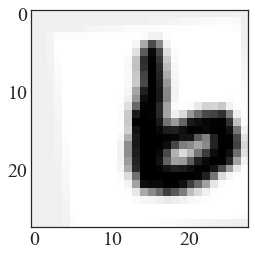

In [51]:
ind=251000-1
print ind
plt.imshow(all_data[ind])

In [52]:

#Add extra dimension
dims=all_data.shape
print (dims)
trainee=all_data.reshape(dims[0],dims[1],dims[2],1)
print (trainee.shape)

dims=X_test.shape
print (dims)
testee=X_test.reshape(dims[0],dims[1],dims[2],1)
print (testee.shape)

#To categorical
from keras.utils.np_utils import to_categorical
train_labels= to_categorical(all_labels)
num_classes = train_labels.shape[1]

print num_classes

(252000, 28, 28)
(252000, 28, 28, 1)
(28000, 28, 28, 1)
(28000, 28, 28, 1)
10


# Home-brewed CNN

In [56]:
import keras
from keras.layers import Conv2D, MaxPool2D
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import backend as K
from keras.utils import to_categorical

K.clear_session()
np.random.seed(123)
model=Sequential()

model.add(Conv2D(32,(3,3), activation='relu', input_shape=(28,28,1),data_format='channels_last'))
model.add(Conv2D(32,(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(1200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print (model.summary())


checkpoints=keras.callbacks.ModelCheckpoint('tmp_models/weights.{epoch:02d}.hdf5', monitor='val_loss', 
                                verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

history=model.fit(trainee, train_labels, batch_size=100, verbose=1, epochs=20, validation_split = 0.1, callbacks=[checkpoints])
#score=model.evaluate(testee, test_labels, verbose=1)
#print (score)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
__________

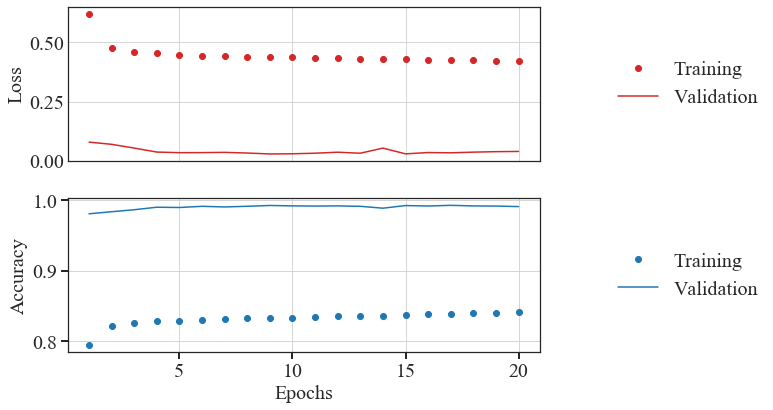

In [57]:
hist=history
epochs=np.asarray(history.epoch)+1

%matplotlib inline
import matplotlib
plt.style.use('seaborn-white')
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20

f, axarr = plt.subplots(2, sharex=True, figsize=(8, 6))

axarr[0].set(ylabel='Loss')
axarr[0].plot(epochs,hist.history['loss'], 'C3o', label='Training')
axarr[0].plot(epochs,hist.history['val_loss'], 'C3-', label='Validation')
axarr[0].grid()
axarr[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))


axarr[1].plot(epochs,hist.history['acc'], 'C0o', label='Training')
axarr[1].plot(epochs,hist.history['val_acc'], 'C0-', label='Validation')
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.grid()
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=7)
plt.tick_params(which='minor', length=5)

# Use model trained on Keras mnist data set in parent folder

Training using the competitions' training data gives only ~99.2% accuracy even with augmentation

Using the model trained on dataset that came with Keras got ~99.76% accuracy

In [58]:
from keras.models import Model, load_model
model=load_model('../tmp_models/weights.08.hdf5')

predictions = model.predict_classes(X_test, verbose=0)

submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("submit.csv", index=False, header=True)